In this notebook we explore paramaters of a convolutional neural network using the malaria cell images dataset, including the number of convolutional layers, number of filters, kernel size, and max pooling vs without. Besides some additional imports, the beginning of the notebook up to the first neural network is identical to Q2.ipynb. Please refer to the markdown comments in that notebook for the beginning of this one. 

This notebook should be run on Google Colab. 

In [ ]:
# Importing necessary modules
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import Input
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Importing functions from functions.py. This gets them from GitHub.

!wget -O functions.py https://raw.githubusercontent.com/up941791/ACT_2/main/py/functions.py
import functions as fn

--2026-01-07 10:38:40--  https://raw.githubusercontent.com/up941791/ACT_2/main/py/functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143 [text/plain]
Saving to: ‘functions.py’

functions.py        100%[===================>]     143  --.-KB/s    in 0s      

2026-01-07 10:38:41 (3.57 MB/s) - ‘functions.py’ saved [143/143]



In [3]:
# Downloading the dataset

os.environ['KAGGLE_USERNAME'] = 'samhedley'
os.environ['KAGGLE_KEY'] = 'KGAT_b7cd8b87cb2a0346ef10f-b182f099721'
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria --unzip

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 98% 664M/675M [00:03<00:00, 48.9MB/s]
100% 675M/675M [00:03<00:00, 185MB/s] 


In [4]:
data_dir = "./cell_images" # Directory for the dataset

In [5]:
# Function to split dataset paths into training, validation, and test set paths
def split_dataset_paths(folder_path, test_size, val_size):

    split_paths = {'train': [], 'val': [], 'test': []}

    for label in ['Parasitized', 'Uninfected']: # Looping through both classes
        imgs = [] # List to hold valid image paths
        class_dir = os.path.join(folder_path, label) # Directory for the current class
        for img_name in os.listdir(class_dir): # Looping through images in the class directory
            img_path = os.path.join(class_dir, img_name) # Full path to the image
            
            imgs.append((img_path, label)) # Append image path and label

        train_imgs, temp_imgs = train_test_split(imgs, test_size=test_size + val_size, random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_size / (test_size + val_size), random_state=42)

        split_paths['train'].extend(train_imgs)
        split_paths['val'].extend(val_imgs)
        split_paths['test'].extend(test_imgs)

    return split_paths

In [6]:
# Splitting dataset into train, val, and test sets
split_paths = split_dataset_paths(data_dir, test_size=0.15, val_size=0.15) 

In [7]:
# Checking the number of samples in each split
print("Training samples:", len(split_paths['train']))
print("Validation samples:", len(split_paths['val']))
print("Test samples:", len(split_paths['test']))

Training samples: 19292
Validation samples: 4134
Test samples: 4134


In [8]:
# Creating dataframes for each split
train_df = fn.make_dataframe(split_paths, 'train')
val_df = fn.make_dataframe(split_paths, 'val')
test_df = fn.make_dataframe(split_paths, 'test')

In [9]:
# Setting up ImageDataGenerators for training, validation, and test sets

target_size = (128, 128) # Target size for image resizing
batch_size = 64 # Batch size for training and validation

datagen = ImageDataGenerator(rescale=1./255) # Scaling pixel values to [0, 1]

train_gen = datagen.flow_from_dataframe( # Training data generator
    train_df,
    x_col='img_path',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = datagen.flow_from_dataframe( # Validation data generator
    val_df,
    x_col='img_path',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = datagen.flow_from_dataframe( # Test data generator
    test_df,
    x_col='img_path',
    y_col='label',
    target_size=target_size,
    batch_size=1,
    class_mode='binary'
)

Found 19292 validated image filenames belonging to 2 classes.
Found 4133 validated image filenames belonging to 2 classes.
Found 4133 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


In [10]:
# Setting up model checkpoints to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [11]:
# Setting up learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

In [12]:
# Setting up early stopping to stop if the model stops improving
earlystopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    verbose=1,
    restore_best_weights=False
)

In [13]:
# List of callbacks to be used during training
callbacks_list = [checkpoint, reduce_lr, earlystopping]

In [14]:
# Building the CNN model

cNN = Sequential()

cNN.add(Input(shape=(128, 128, 3)))
cNN.add(Conv2D(32, (3, 3), activation='relu'))
cNN.add(MaxPooling2D((2, 2)))
cNN.add(Conv2D(64, (3, 3), activation='relu'))
cNN.add(MaxPooling2D((2, 2)))
cNN.add(Conv2D(128, (3, 3), activation='relu'))
cNN.add(MaxPooling2D((2, 2)))

cNN.add(Flatten())
cNN.add(Dense(64, activation='relu'))
cNN.add(Dropout(0.5))

cNN.add(Dense(1, activation='sigmoid'))

In [15]:
optimiser = Adam(learning_rate=0.001) # Setting the optimiser

cNN.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()]) # Compiling the model

In [16]:
# Training the model
model1 = cNN.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks_list
)

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6897 - loss: 0.5756 - precision: 0.6865 - recall: 0.6860
Epoch 1: val_accuracy improved from -inf to 0.93346, saving model to best_model.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 40s 109ms/step - accuracy: 0.6901 - loss: 0.5750 - precision: 0.6869 - recall: 0.6864 - val_accuracy: 0.9335 - val_loss: 0.1928 - val_precision: 0.9191 - val_recall: 0.9507 - learning_rate: 0.0010
Epoch 2/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9377 - loss: 0.2027 - precision: 0.9337 - recall: 0.9419
Epoch 2: val_accuracy improved from 0.93346 to 0.94580, saving model to best_model.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - accuracy: 0.9377 - loss: 0.2026 - precision: 0.9337 - recall: 0.9419 - val_accuracy: 0.9458 - val_loss: 0.1591 - val_precision: 0.9332 - val_recall: 0.9603 - learning_rate: 0.0010
Epoch 3/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9433 - loss: 0.1674 - precision: 0.9377 - recall: 0.9499
Epoch 3: val_

In [17]:
# Testing the model on the test set

cNN.load_weights('best_model.keras') # Loading the best model weights

test_loss, test_acc, precision, recall = cNN.evaluate(test_gen) # Evaluating on the test set

# Printing test results
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test Precision: {precision:.4f}")

4133/4133 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9452 - loss: 0.1868 - precision: 0.9129 - recall: 0.9776
Test Accuracy: 0.9526
Test loss: 0.1636
Test Recall: 0.9768
Test Precision: 0.9317


In [18]:
cNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,097,029 (19.44 MB)

 Trainable params: 1,699,009 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,398,020 (12.96 MB)

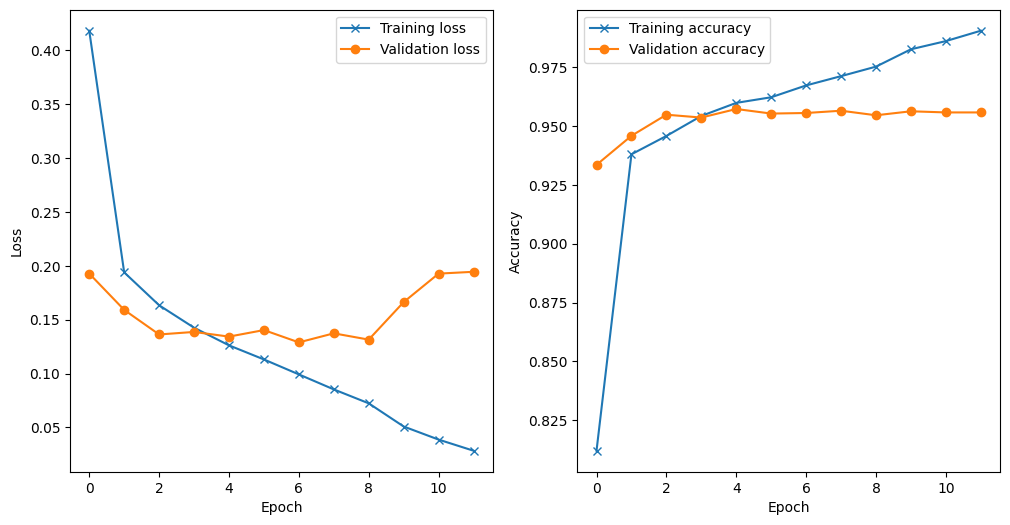

In [19]:
# Plotting loss
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(model1.history['loss'], 'x-', label="Training loss")
plt.plot(model1.history['val_loss'], 'o-', label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(model1.history['accuracy'], 'x-', label="Training accuracy")
plt.plot(model1.history['val_accuracy'], 'o-', label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

Up until now the notebook has been the same as Q2. Now we will begin to investigate different parameters of the convolutional layers. 

First, let's try removing the third convolutional layer (and it's corresponding max pooling layer). This will reduce the depth of the model and capture less complex features. 

In [ ]:
# 2 Convolutional layers (removed 128 filter layer and corresponding maxpooling)

# Setting up model checkpoints to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_model_2.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# List of callbacks to be used during training
callbacks_list_2 = [checkpoint, reduce_lr, earlystopping]

# Building the CNN model

cNN2 = Sequential()

cNN2.add(Input(shape=(128, 128, 3)))
cNN2.add(Conv2D(32, (3, 3), activation='relu'))
cNN2.add(MaxPooling2D((2, 2)))
cNN2.add(Conv2D(64, (3, 3), activation='relu'))
cNN2.add(MaxPooling2D((2, 2)))

cNN2.add(Flatten())
cNN2.add(Dense(64, activation='relu'))
cNN2.add(Dropout(0.5))

cNN2.add(Dense(1, activation='sigmoid'))


optimiser = Adam(learning_rate=0.001) # Setting the optimiser
cNN2.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()]) # Compiling the model

In [21]:
# Training the model
model2 = cNN2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks_list_2
)

Epoch 1/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6237 - loss: 0.6961 - precision_1: 0.6372 - recall_1: 0.5729
Epoch 1: val_accuracy improved from -inf to 0.90298, saving model to best_model_2.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 33s 97ms/step - accuracy: 0.6240 - loss: 0.6956 - precision_1: 0.6374 - recall_1: 0.5734 - val_accuracy: 0.9030 - val_loss: 0.3070 - val_precision_1: 0.9366 - val_recall_1: 0.8645 - learning_rate: 0.0010
Epoch 2/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9083 - loss: 0.2823 - precision_1: 0.9073 - recall_1: 0.9114
Epoch 2: val_accuracy improved from 0.90298 to 0.93007, saving model to best_model_2.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - accuracy: 0.9083 - loss: 0.2823 - precision_1: 0.9073 - recall_1: 0.9115 - val_accuracy: 0.9301 - val_loss: 0.1999 - val_precision_1: 0.9241 - val_recall_1: 0.9371 - learning_rate: 0.0010
Epoch 3/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9306 - loss: 0.2042 - precision_

In [22]:
# Testing the model on the test set

cNN2.load_weights('best_model_2.keras') # Loading the best model weights

test_loss, test_acc, precision, recall = cNN2.evaluate(test_gen) # Evaluating on the test set

# Printing test results
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test Precision: {precision:.4f}")

4133/4133 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9263 - loss: 0.2804 - precision_1: 0.9300 - recall_1: 0.9218
Test Accuracy: 0.9344
Test loss: 0.2704
Test Recall: 0.9361
Test Precision: 0.9329


In [23]:
cNN2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,117,765 (42.41 MB)

 Trainable params: 3,705,921 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,411,844 (28.27 MB)

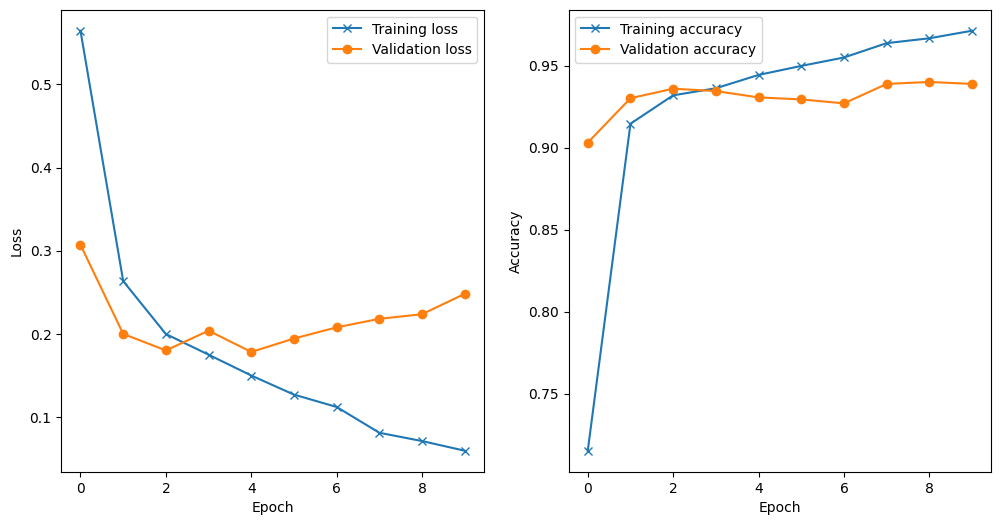

In [24]:
# Plotting loss
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(model2.history['loss'], 'x-', label="Training loss")
plt.plot(model2.history['val_loss'], 'o-', label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(model2.history['accuracy'], 'x-', label="Training accuracy")
plt.plot(model2.history['val_accuracy'], 'o-', label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

As we can see, the test accuracy dropped by a couple of percentage points. This makes sense, as the model is unable to capture as much complexity in the images now. So it appears that 3 layers is suitable for our task, whereas 2 layers is underfitting. We also have 11.1 million parameters instead of 5.1 million.

Now let's return to three layers, but quarter the number of filters in each layer - from 32/64/128 to 8/16/32. This will reduce the number of features the model can capture at each level (layer), reducing the variety of patterns it can learn.

In [ ]:
# 3 Convolutional layers with reduced filters (8, 16, 32)

# Setting up model checkpoints to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_model_3.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# List of callbacks to be used during training
callbacks_list_3 = [checkpoint, reduce_lr, earlystopping]

# Building the CNN model

cNN3 = Sequential()

cNN3.add(Input(shape=(128, 128, 3)))
cNN3.add(Conv2D(8, (3, 3), activation='relu'))
cNN3.add(MaxPooling2D((2, 2)))
cNN3.add(Conv2D(16, (3, 3), activation='relu'))
cNN3.add(MaxPooling2D((2, 2)))
cNN3.add(Conv2D(32, (3, 3), activation='relu'))
cNN3.add(MaxPooling2D((2, 2)))

cNN3.add(Flatten())
cNN3.add(Dense(64, activation='relu'))
cNN3.add(Dropout(0.5))
cNN3.add(Dense(1, activation='sigmoid'))


optimiser = Adam(learning_rate=0.001) # Setting the optimiser
cNN3.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()]) # Compiling the model

In [26]:
# Training the model
model3 = cNN3.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks_list_3
)

Epoch 1/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6647 - loss: 0.5995 - precision_2: 0.6557 - recall_2: 0.7074
Epoch 1: val_accuracy improved from -inf to 0.92790, saving model to best_model_3.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 34s 99ms/step - accuracy: 0.6650 - loss: 0.5991 - precision_2: 0.6560 - recall_2: 0.7077 - val_accuracy: 0.9279 - val_loss: 0.2598 - val_precision_2: 0.9250 - val_recall_2: 0.9313 - learning_rate: 0.0010
Epoch 2/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9033 - loss: 0.2990 - precision_2: 0.9219 - recall_2: 0.8816
Epoch 2: val_accuracy improved from 0.92790 to 0.93032, saving model to best_model_3.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - accuracy: 0.9033 - loss: 0.2989 - precision_2: 0.9220 - recall_2: 0.8816 - val_accuracy: 0.9303 - val_loss: 0.1858 - val_precision_2: 0.9531 - val_recall_2: 0.9052 - learning_rate: 0.0010
Epoch 3/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9236 - loss: 0.2248 - precision_

In [27]:
# Testing the model on the test set

cNN3.load_weights('best_model_3.keras') # Loading the best model weights

test_loss, test_acc, precision, recall = cNN3.evaluate(test_gen) # Evaluating on the test set

# Printing test results
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test Precision: {precision:.4f}")

4133/4133 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9542 - loss: 0.1400 - precision_2: 0.9492 - recall_2: 0.9640
Test Accuracy: 0.9494
Test loss: 0.1552
Test Recall: 0.9637
Test Precision: 0.9369


In [28]:
cNN3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 126, 126, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 63, 63, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 61, 61, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,222,709 (4.66 MB)

 Trainable params: 407,569 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 815,140 (3.11 MB)

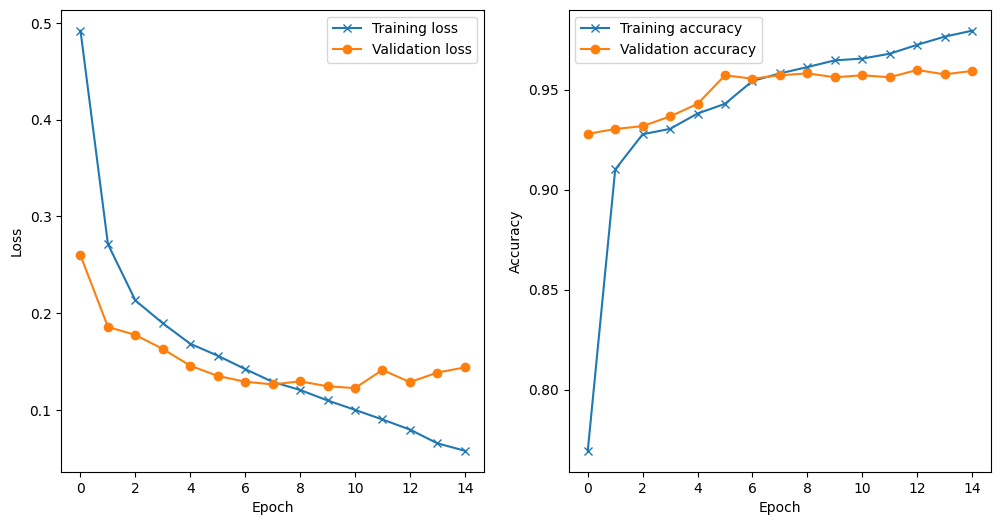

In [29]:
# Plotting loss
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(model3.history['loss'], 'x-', label="Training loss")
plt.plot(model3.history['val_loss'], 'o-', label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(model3.history['accuracy'], 'x-', label="Training accuracy")
plt.plot(model3.history['val_accuracy'], 'o-', label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

This time the difference in test accuracy (as well as validation accuracy) between this model and the baseline model is insignificant. We can also see that the validation loss and accuracy curves are a bit more stable, and diverge from the training curves less. This suggests that we're overfitting less compared to the baseline model. All of this implies that our original model had more than enough filters to capture the necessary amount of features at each level. Reducing the number of filters has also decreased our number of parameters significantly - 1.2 million compared to the original 5.1 million.

So what if we quarter the number of filters again? Will this still have enough capacity, or will it begin to underfit? Let's try 2/4/8 filters.

In [ ]:
# 3 Convolutional layers with further reduced filters (2, 4, 8)

# Setting up model checkpoints to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_model_4.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# List of callbacks to be used during training
callbacks_list_4 = [checkpoint, reduce_lr, earlystopping]

# Building the CNN model

cNN4 = Sequential()
cNN4.add(Input(shape=(128, 128, 3)))
cNN4.add(Conv2D(2, (3, 3), activation='relu'))
cNN4.add(MaxPooling2D((2, 2)))
cNN4.add(Conv2D(4, (3, 3), activation='relu'))
cNN4.add(MaxPooling2D((2, 2)))
cNN4.add(Conv2D(8, (3, 3), activation='relu'))
cNN4.add(MaxPooling2D((2, 2)))

cNN4.add(Flatten())
cNN4.add(Dense(64, activation='relu'))
cNN4.add(Dropout(0.5))
cNN4.add(Dense(1, activation='sigmoid'))


optimiser = Adam(learning_rate=0.001) # Setting the optimiser
cNN4.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()]) # Compiling the model

In [31]:
# Training the model
model4 = cNN4.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks_list_4
)

Epoch 1/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6802 - loss: 0.5848 - precision_3: 0.6957 - recall_3: 0.5944
Epoch 1: val_accuracy improved from -inf to 0.90394, saving model to best_model_4.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 38s 113ms/step - accuracy: 0.6805 - loss: 0.5845 - precision_3: 0.6959 - recall_3: 0.5949 - val_accuracy: 0.9039 - val_loss: 0.2589 - val_precision_3: 0.8995 - val_recall_3: 0.9095 - learning_rate: 0.0010
Epoch 2/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9129 - loss: 0.2253 - precision_3: 0.9260 - recall_3: 0.8979
Epoch 2: val_accuracy improved from 0.90394 to 0.94629, saving model to best_model_4.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 26s 86ms/step - accuracy: 0.9129 - loss: 0.2253 - precision_3: 0.9260 - recall_3: 0.8980 - val_accuracy: 0.9463 - val_loss: 0.1634 - val_precision_3: 0.9467 - val_recall_3: 0.9458 - learning_rate: 0.0010
Epoch 3/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9443 - loss: 0.1691 - precision

In [32]:
# Testing the model on the test set

cNN4.load_weights('best_model_4.keras') # Loading the best model weights

test_loss, test_acc, precision, recall = cNN4.evaluate(test_gen) # Evaluating on the test set

# Printing test results
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test Precision: {precision:.4f}")

4133/4133 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9472 - loss: 0.1685 - precision_3: 0.9313 - recall_3: 0.9662
Test Accuracy: 0.9528
Test loss: 0.1561
Test Recall: 0.9647
Test Precision: 0.9423


In [33]:
cNN4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 126, 126, 2)    │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 61, 4)      │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 302,729 (1.15 MB)

 Trainable params: 100,909 (394.18 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 201,820 (788.36 KB)

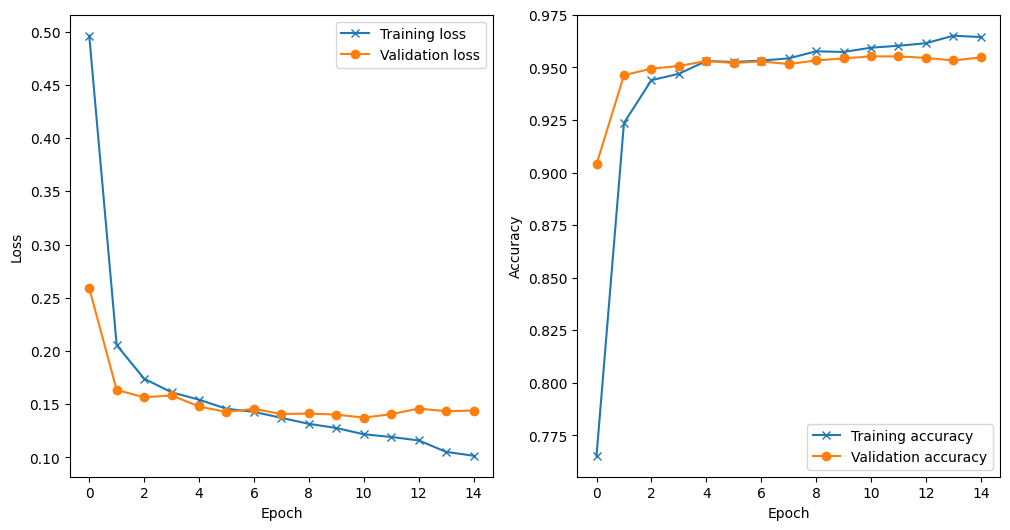

In [34]:
# Plotting loss
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(model4.history['loss'], 'x-', label="Training loss")
plt.plot(model4.history['val_loss'], 'o-', label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(model4.history['accuracy'], 'x-', label="Training accuracy")
plt.plot(model4.history['val_accuracy'], 'o-', label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

Once again, the test and validation accuracies haven't changed by any meaningful amount. However, the validation and training curves are now even more similar - we are overfitting even less. So our original model clearly had more than enough filters per layer, and even with one sixteenth of the filters per layer we're achieving more or less the same accuracy, but with less overfitting. This makes sense when we look at the images we plotted in Q1 - there aren't many features in our images. Also we now have 303 thousand parameters - less than 10% compared to the original network.

Now let's return to our baseline model, and now change the kernel size in each convolutional layer from 3x3 to 5x5. This will increase the region of inputs that each neuron sees at once, and in our case might lead to more overfitting.

In [ ]:
# 3 Convolutional layers with 5x5 kernel size

# Setting up model checkpoints to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_model_5.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# List of callbacks to be used during training
callbacks_list_5 = [checkpoint, reduce_lr, earlystopping]

# Building the CNN model

cNN5 = Sequential()

cNN5.add(Input(shape=(128, 128, 3)))
cNN5.add(Conv2D(32, (5, 5), activation='relu'))
cNN5.add(MaxPooling2D((2, 2)))
cNN5.add(Conv2D(64, (5, 5), activation='relu'))
cNN5.add(MaxPooling2D((2, 2)))
cNN5.add(Conv2D(128, (5, 5), activation='relu'))
cNN5.add(MaxPooling2D((2, 2)))

cNN5.add(Flatten())
cNN5.add(Dense(64, activation='relu'))
cNN5.add(Dropout(0.5))
cNN5.add(Dense(1, activation='sigmoid'))


optimiser = Adam(learning_rate=0.001) # Setting the optimiser
cNN5.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()]) # Compiling the model

In [36]:
# Training the model
model5 = cNN5.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks_list_5
)

Epoch 1/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5585 - loss: 0.6697 - precision_4: 0.5498 - recall_4: 0.4577
Epoch 1: val_accuracy improved from -inf to 0.92112, saving model to best_model_5.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 42s 116ms/step - accuracy: 0.5588 - loss: 0.6693 - precision_4: 0.5502 - recall_4: 0.4583 - val_accuracy: 0.9211 - val_loss: 0.2248 - val_precision_4: 0.9104 - val_recall_4: 0.9342 - learning_rate: 0.0010
Epoch 2/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9225 - loss: 0.2234 - precision_4: 0.9364 - recall_4: 0.9090
Epoch 2: val_accuracy improved from 0.92112 to 0.93661, saving model to best_model_5.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 28s 94ms/step - accuracy: 0.9226 - loss: 0.2233 - precision_4: 0.9364 - recall_4: 0.9091 - val_accuracy: 0.9366 - val_loss: 0.1671 - val_precision_4: 0.9524 - val_recall_4: 0.9192 - learning_rate: 0.0010
Epoch 3/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9389 - loss: 0.1755 - precision

In [37]:
# Testing the model on the test set

cNN5.load_weights('best_model_5.keras') # Loading the best model weights

test_loss, test_acc, precision, recall = cNN5.evaluate(test_gen) # Evaluating on the test set

# Printing test results
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test Precision: {precision:.4f}")

4133/4133 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9550 - loss: 0.1519 - precision_4: 0.9446 - recall_4: 0.9669
Test Accuracy: 0.9545
Test loss: 0.1455
Test Recall: 0.9666
Test Precision: 0.9438


In [38]:
cNN5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 58, 58, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 25, 25, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     1,179,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,315,205 (16.46 MB)

 Trainable params: 1,438,401 (5.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,876,804 (10.97 MB)

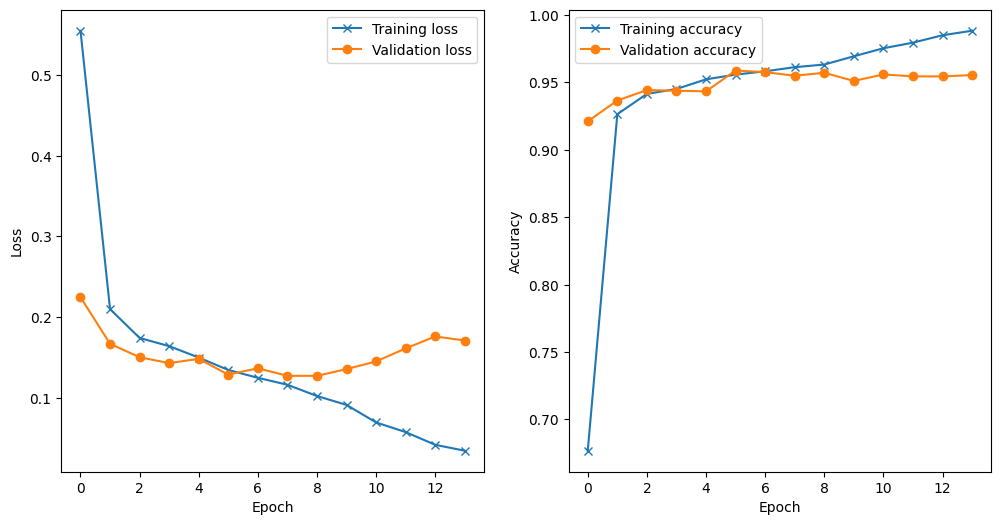

In [39]:
# Plotting loss
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(model5.history['loss'], 'x-', label="Training loss")
plt.plot(model5.history['val_loss'], 'o-', label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(model5.history['accuracy'], 'x-', label="Training accuracy")
plt.plot(model5.history['val_accuracy'], 'o-', label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

And once again, the test accuracy is more or less the same as the baseline model. We're also back to overfitting, though it doesn't seem worse than the original model. As for the number of the parameters, this has decreased slightly to 4.3 million.

Finally, let's see what happens if we remove the max pooling layers. This will increase the number of parameters drastically, as well as reducing translation invariance. 

In [ ]:
# 3 Convolutional layers without any pooling

# Setting up model checkpoints to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_model_6.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# List of callbacks to be used during training
callbacks_list_6 = [checkpoint, reduce_lr, earlystopping]

# Building the CNN model

cNN6 = Sequential()

cNN6.add(Input(shape=(128, 128, 3)))
cNN6.add(Conv2D(32, (3, 3), activation='relu'))
cNN6.add(Conv2D(64, (3, 3), activation='relu'))
cNN6.add(Conv2D(128, (3, 3), activation='relu'))

cNN6.add(Flatten())
cNN6.add(Dense(64, activation='relu'))
cNN6.add(Dropout(0.5))
cNN6.add(Dense(1, activation='sigmoid'))


optimiser = Adam(learning_rate=0.001) # Setting the optimiser
cNN6.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()]) # Compiling the model

In [41]:
# Training the model
model6 = cNN6.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks_list_6
)

Epoch 1/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.5802 - loss: 1.9607 - precision_5: 0.5731 - recall_5: 0.6039
Epoch 1: val_accuracy improved from -inf to 0.91144, saving model to best_model_6.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 109s 302ms/step - accuracy: 0.5806 - loss: 1.9570 - precision_5: 0.5735 - recall_5: 0.6043 - val_accuracy: 0.9114 - val_loss: 0.3228 - val_precision_5: 0.9355 - val_recall_5: 0.8839 - learning_rate: 0.0010
Epoch 2/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9129 - loss: 0.2937 - precision_5: 0.8933 - recall_5: 0.9382
Epoch 2: val_accuracy improved from 0.91144 to 0.92814, saving model to best_model_6.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 113s 373ms/step - accuracy: 0.9129 - loss: 0.2937 - precision_5: 0.8933 - recall_5: 0.9382 - val_accuracy: 0.9281 - val_loss: 0.2136 - val_precision_5: 0.9230 - val_recall_5: 0.9342 - learning_rate: 0.0010
Epoch 3/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9320 - loss: 0.2058 - pre

In [42]:
# Testing the model on the test set

cNN6.load_weights('best_model_6.keras') # Loading the best model weights

test_loss, test_acc, precision, recall = cNN6.evaluate(test_gen) # Evaluating on the test set

# Printing test results
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test Precision: {precision:.4f}")

4133/4133 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.9295 - loss: 0.2712 - precision_5: 0.9203 - recall_5: 0.9382
Test Accuracy: 0.9325
Test loss: 0.2292
Test Recall: 0.9356
Test Precision: 0.9298


In [43]:
cNN6.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 122, 122, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1905152)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │   121,929,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 366,069,317 (1.36 GB)

 Trainable params: 122,023,105 (465.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 244,046,212 (930.96 MB)

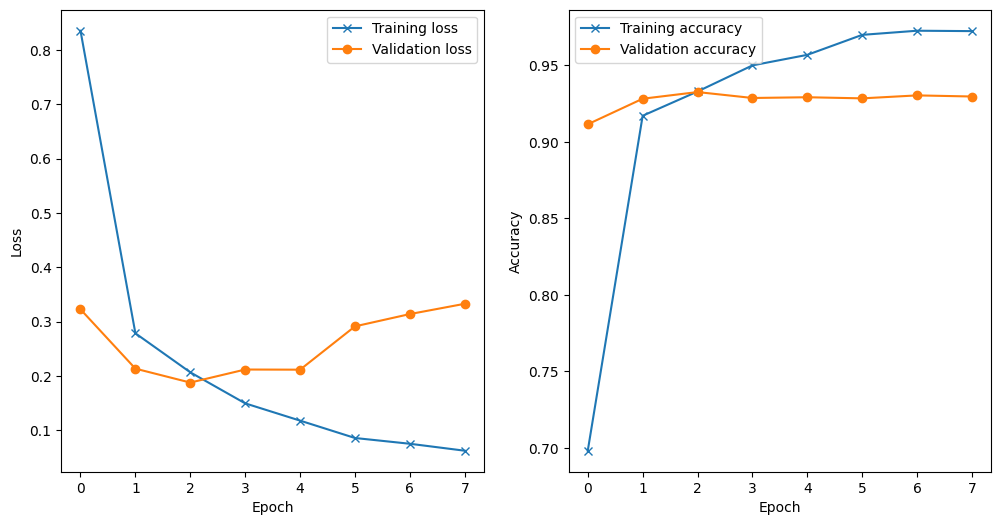

In [44]:
# Plotting loss
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(model6.history['loss'], 'x-', label="Training loss")
plt.plot(model6.history['val_loss'], 'o-', label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(model6.history['accuracy'], 'x-', label="Training accuracy")
plt.plot(model6.history['val_accuracy'], 'o-', label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

The model now doesn't always train stably. You can run it with varied results - sometimes it may plateau around 93% validation accuracy, other times it may only reach 60% or fail to train at all and stay around 50% which is no better than random guessing. It also takes more than twice as long to train per epoch, and a considerable amount of time to save the weights when the model improves. This isn't surprising considering there's now 366 million parameters. As for the model failing to train consistently, this is likely due to gradient instability.


Let's plot the validation accuracy per epoch for each of the models for comparison.

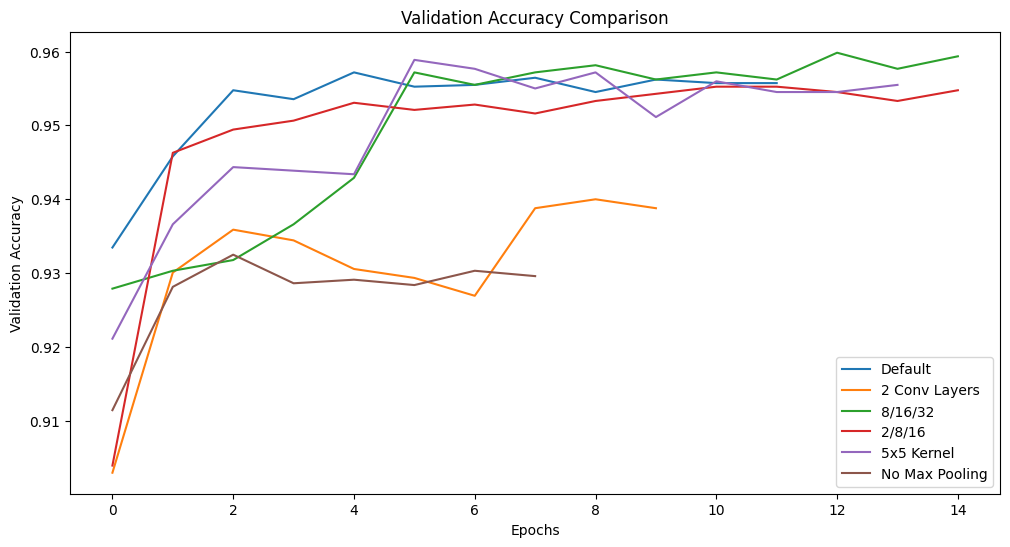

In [45]:
histories = {
    'Default': model1,
    '2 Conv Layers': model2,
    '8/16/32': model3,
    '2/8/16': model4,
    '5x5 Kernel': model5,
    'No Max Pooling': model6
}

# Plotting all model accuracies for comparison
plt.figure(figsize=(12,6))
for name, history in histories.items():
    plt.plot(history.history['val_accuracy'], label=name)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

We can see that the 2 convolutional layer and no max pooling models don't perform as well as the other models, which all perform very similarly towards the end. 

Now let's create a plot for validation loss.

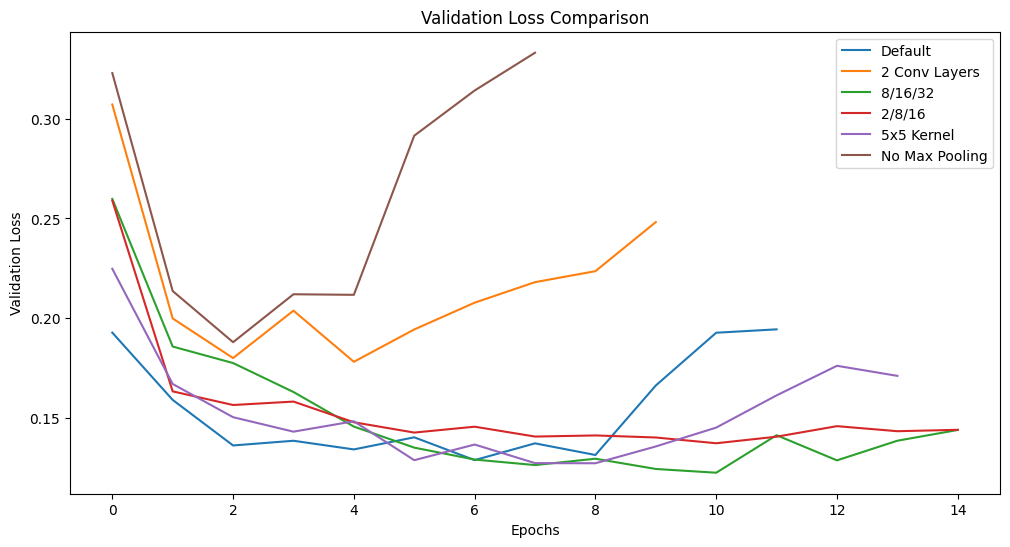

In [46]:
# Plotting all model losses for comparison
plt.figure(figsize=(12,6))
for name, history in histories.items():
    plt.plot(history.history['val_loss'], label=name)
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

Here we can see that the no max pooling model's validation loss increases sharply after a few epochs, demonstrating instability. The 2 convolutional layer model also increases in loss after the first few epochs. The two models with reduced numbers of filters have a more stable validation loss curve compared to the others, and the baseline model and 5x5 kernel models' curves are between. 

Finally, training accuracy...

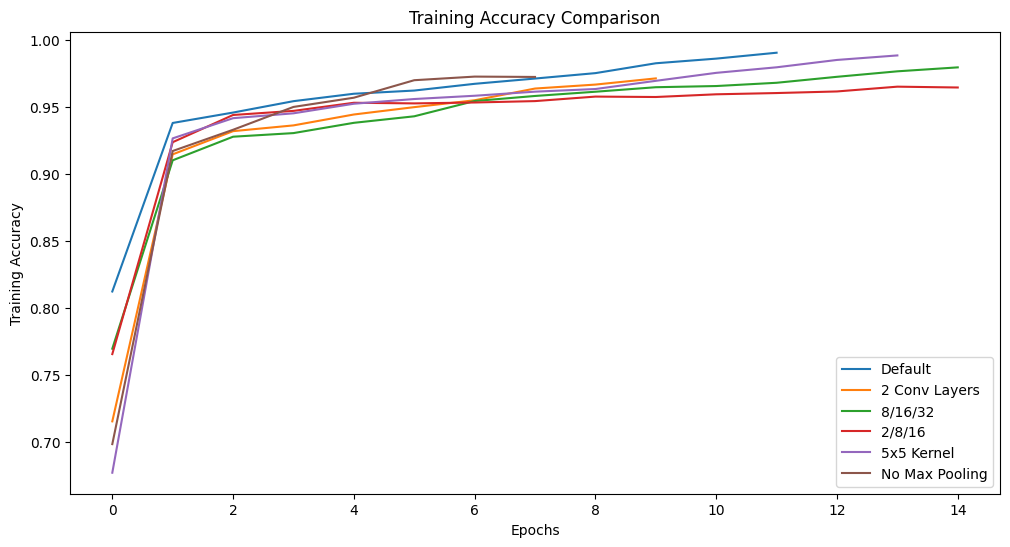

In [49]:
# Plotting all model training accuracies for comparison
plt.figure(figsize=(12,6))
for name, history in histories.items():
    plt.plot(history.history['accuracy'], label=name)
plt.title('Training Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

Here we see that training accuracy increases consistently for each model (except sometimes the no max pooling model). Expectedly from earlier conclusions, the two models with reduced numbers of filters have lower training accuracies - this is because they overfit less. 

In conclusion, our original model had enough capacity to fit our dataset, and actually overfit somewhat, especially compared to the 2/4/8 filter model. We've seen how the number of filters and convolutional layers can affect underfitting/overfitting, as well as how removing pooling layers can lead to excessive training times and training instability. Clearly, it's important to understand how parameters of a convolutional neural network impact its performance so that we can create effective models to make predictions. 